In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
# Hyperparameters
img_size = 128
batch_size = 64
data_dir1 = '../../../chest_xray/train/PNEUMONIA'
data_dir2 = '../../../chest_xray/train/NORMAL'
epochs = 20

In [31]:
def load_data(data_dir1, data_dir2, limit=100):
    print("Chargement des données...")
    data = []
    labels = ['PNEUMONIA', 'NORMAL']
    for dir in [data_dir1, data_dir2]:
        path = os.path.join(dir)
        if not os.path.exists(path):
            print(f"Le répertoire {path} n'existe pas")
            continue
        label = os.path.basename(dir)
        class_num = labels.index(label)
        for i, img in enumerate(os.listdir(path)):
            if i >= limit:
                break
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Impossible de lire {img}. Ignoré.")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    print("Chargement des données terminé.")
    return np.array(data, dtype=object)

# Chargement des données
train_data = load_data(data_dir1, data_dir2, limit=100)

Chargement des données...
Chargement des données terminé.


In [33]:
def preprocess_image(image):
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    image = image / 255.0  # Normalisation
    return image

def preprocess_data(data):
    print("Prétraitement des données...")
    processed_data = []
    for idx, (img, label) in enumerate(data):
        print(f"Traitement de l'image {idx+1}/{len(data)}")
        img = preprocess_image(img)
        processed_data.append([img, label])
    return np.array(processed_data, dtype=object)

train_data = preprocess_data(train_data)

def separate_features_labels(data):
    images, labels = zip(*data)
    return np.array(images), np.array(labels)

x, y = separate_features_labels(train_data)

x = np.array([tf.image.resize(img, [img_size, img_size]) for img in x])
x = x.reshape((x.shape[0], -1))  # Aplatir les images pour XGBoost

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

Prétraitement des données...
Traitement de l'image 1/200
Traitement de l'image 2/200
Traitement de l'image 3/200
Traitement de l'image 4/200
Traitement de l'image 5/200
Traitement de l'image 6/200
Traitement de l'image 7/200
Traitement de l'image 8/200
Traitement de l'image 9/200
Traitement de l'image 10/200
Traitement de l'image 11/200
Traitement de l'image 12/200
Traitement de l'image 13/200
Traitement de l'image 14/200
Traitement de l'image 15/200
Traitement de l'image 16/200
Traitement de l'image 17/200
Traitement de l'image 18/200
Traitement de l'image 19/200
Traitement de l'image 20/200
Traitement de l'image 21/200
Traitement de l'image 22/200
Traitement de l'image 23/200
Traitement de l'image 24/200
Traitement de l'image 25/200
Traitement de l'image 26/200
Traitement de l'image 27/200
Traitement de l'image 28/200
Traitement de l'image 29/200
Traitement de l'image 30/200
Traitement de l'image 31/200
Traitement de l'image 32/200
Traitement de l'image 33/200
Traitement de l'image 3

In [35]:
# Preprocessing image and data
def preprocess_image(image):
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    image = image / 255.0  # Normalisation
    return image

def preprocess_data(data):
    print("Prétraitement des données...")
    processed_data = []
    for idx, (img, label) in enumerate(data):
        img = preprocess_image(img)
        processed_data.append([img, label])
    return np.array(processed_data, dtype=object)

# Separate features and labels
def separate_features_labels(data):
    images, labels = zip(*data)
    return np.array(images), np.array(labels)

# Train/validation split and reshape for XGBoost
train_data = preprocess_data(load_data(data_dir1, data_dir2, limit=100))
x, y = separate_features_labels(train_data)

x = np.array([tf.image.resize(img, [img_size, img_size]) for img in x])
x = x.reshape((x.shape[0], -1))  # Aplatir les images pour XGBoost

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

Chargement des données...
Chargement des données terminé.
Prétraitement des données...


In [37]:
# Build GBM model
def build_gbm_model():
    model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
    model.fit(x_train, y_train)
    return model

# Entraînement du modèle GBM
gbm_model = build_gbm_model()

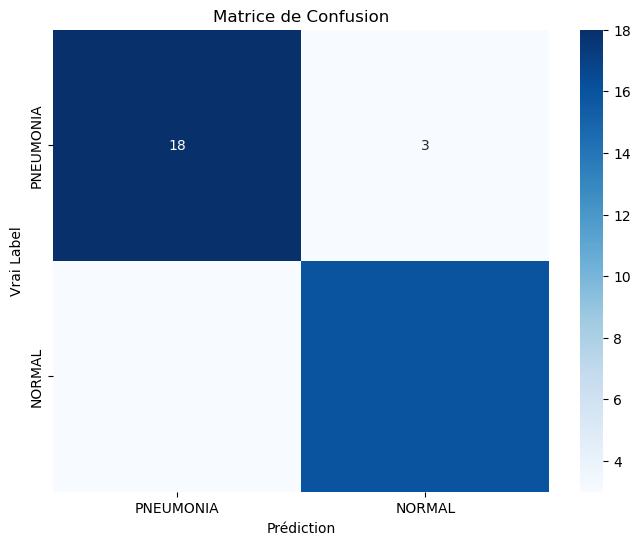

Rapport de Classification :
               precision    recall  f1-score   support

   PNEUMONIA       0.86      0.86      0.86        21
      NORMAL       0.84      0.84      0.84        19

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40



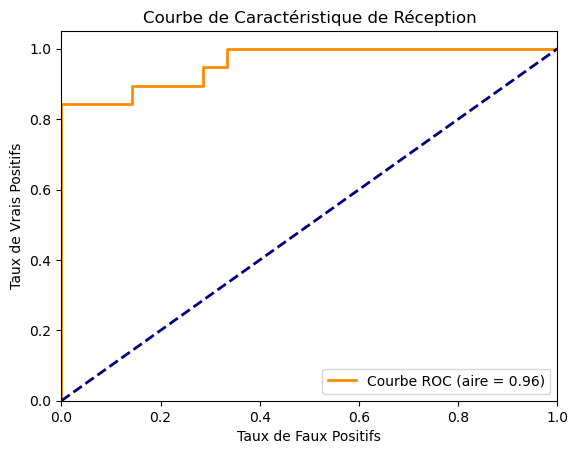

In [39]:
# Evaluation of the model
def evaluate_model(model, x_val, y_val):
    y_pred = model.predict(x_val)
    cm = confusion_matrix(y_val, y_pred)
    cr = classification_report(y_val, y_pred, target_names=['PNEUMONIA', 'NORMAL'])
    
    # Matrice de Confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['PNEUMONIA', 'NORMAL'], yticklabels=['PNEUMONIA', 'NORMAL'])
    plt.ylabel('Vrai Label')
    plt.xlabel('Prédiction')
    plt.title('Matrice de Confusion')
    plt.show()

    # Rapport de Classification
    print("Rapport de Classification :\n", cr)

    # ROC et AUC
    y_prob = model.predict_proba(x_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (aire = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title('Courbe de Caractéristique de Réception')
    plt.legend(loc="lower right")
    plt.show()

# Appel de la fonction d'évaluation
evaluate_model(gbm_model, x_val, y_val)

In [41]:
# K-Fold Cross-Validation
def k_fold_cross_validation(model, x, y, k=5):
    kf = KFold(n_splits=k)
    accuracies = []
    
    for train_idx, val_idx in kf.split(x):
        x_train_fold, x_val_fold = x[train_idx], x[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        model.fit(x_train_fold, y_train_fold)
        accuracy = model.score(x_val_fold, y_val_fold)
        accuracies.append(accuracy)
    
    print(f"Précision moyenne en validation croisée K-Fold : {np.mean(accuracies)}")
    return np.mean(accuracies)

# Appel de la fonction de validation croisée
k_fold_accuracy = k_fold_cross_validation(gbm_model, x, y)

Précision moyenne en validation croisée K-Fold : 0.8100000000000002


In [42]:
# Saving the model
gbm_model.save_model('gbm_model.json')
print("Model saved")

# Load the saved model
loaded_model = XGBClassifier()
loaded_model.load_model('gbm_model.json')
print("Model loaded")

Model saved
Model loaded


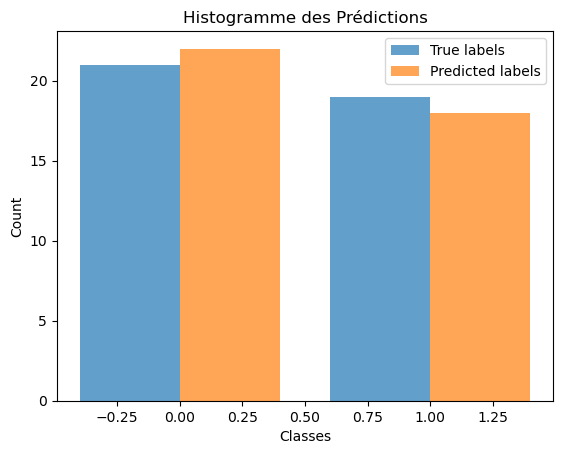

In [43]:
# Plotting prediction histogram
def plot_prediction_histogram(y_true, y_pred):
    plt.figure()
    plt.hist([y_true, y_pred], bins=np.arange(3) - 0.5, label=['True labels', 'Predicted labels'], alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Histogramme des Prédictions')
    plt.legend()
    plt.show()

# Prédictions avec le modèle chargé
y_pred = loaded_model.predict(x_val)
plot_prediction_histogram(y_val, y_pred)

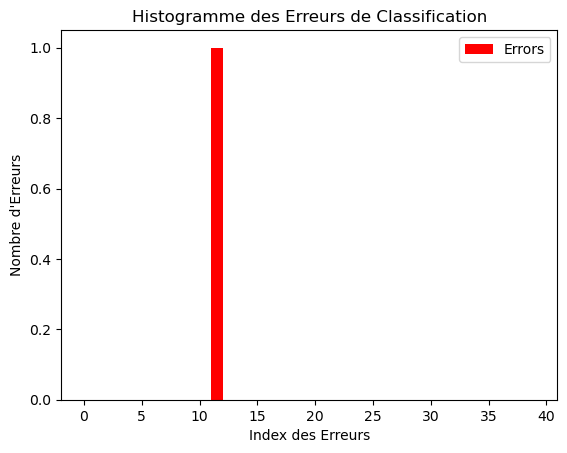

In [44]:
# Plotting classification errors
def plot_errors(y_true, y_pred):
    errors = y_true != y_pred
    plt.figure()
    plt.hist(np.where(errors)[0], bins=range(len(y_true)), label='Errors', color='red')
    plt.xlabel('Index des Erreurs')
    plt.ylabel('Nombre d\'Erreurs')
    plt.title('Histogramme des Erreurs de Classification')
    plt.legend()
    plt.show()

# Appel de la fonction plot_errors
plot_errors(y_val, y_pred)